In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image

import ssl
import certifi
ssl._create_default_https_context = ssl._create_unverified_context

In [19]:
device = 'mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device = " + device)
if device == 'cpu':
    print("WARNING: Using CPU will cause slower train times")

Using device = cuda


In [20]:
# Load VGG19 model
model = models.vgg19(pretrained=True).features

C:\Users\hanna\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\hanna\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Look at which convolutional layers we want to use for the style transfer

In [21]:
print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [22]:
conv_layers = ['0', '5', '10', '19', '28']

In [23]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        
        self.chosen_features = ['0', '5', '10', '19', '28']
        self.model = models.vgg19(pretrained=True).features[:29]
        
    def forward(self, x):
        features = []
        
        for layer_num, layer in enumerate(self.model):
            x = layer(x)
            
            if str(layer_num) in self.chosen_features:
                features.append(x)
                
        return features

In [24]:
model = VGG().to(device).eval()

In [25]:
def load_image(image_name, image_size=256):
    loader = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ])
    
    image = Image.open(image_name)
    image = image.convert('RGB')
    image = loader(image).unsqueeze(0)
    return image.to(device)

In [26]:
image_size = 256
content = load_image("style-images/i-house.png", image_size)
style = load_image("style-images/face-lift-brick.png", image_size)
#mask = load_image("style-images/i-house-mask-01.png", image_size)

In [27]:
type(content)

torch.Tensor

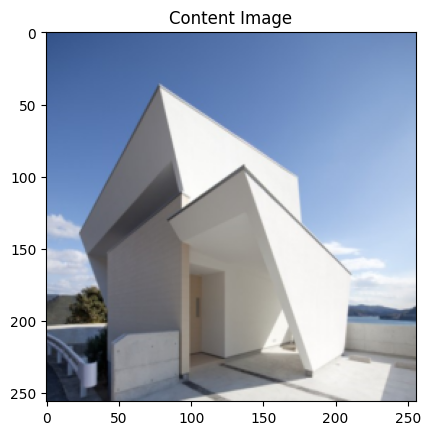

In [28]:
# display the images
unloader = transforms.ToPILImage()
import matplotlib.pyplot as plt
    
plt.ion()
    
def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
plt.figure()
imshow(content, title='Content Image')

In [29]:
generated = content.clone().requires_grad_(True)

# Hyperparameters

In [30]:
total_steps = 6000
learning_rate = 0.001
alpha = 1 # content loss
beta = 0.01 # style loss

In [31]:
optimizer = optim.Adam([generated], lr=learning_rate, betas=[0.5, 0.999])

In [ ]:
for step in range(total_steps):
    generated_features = model(generated)
    content_features = model(content)
    style_features = model(style)
    
    style_loss =0
    content_loss = 0
    
    for gen_feature, content_feature, style_feature in zip(generated_features,content_features, style_features):
        batch_size, channel, height, width = gen_feature.shape
        
        content_loss += torch.mean((gen_feature - content_feature)**2)
        
        # Compute Gram Matrix
        G_gen = gen_feature.view(channel, height*width).mm(gen_feature.view(channel, height*width).t())
        G_style = style_feature.view(channel, height*width).mm(style_feature.view(channel, height*width).t())
        
        style_loss += torch.mean((G_gen - G_style)**2)
        
    total_loss = alpha*content_loss + beta*style_loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if step % 200 == 0:
        print(total_loss)
        image_name = "image_gens/arch_1/iHouseBrick" + str(step) + ".png"
        save_image(generated, image_name)
    

tensor(123539.3359, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6182.5229, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3623.1663, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2777.5881, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2353.7395, device='cuda:0', grad_fn=<AddBackward0>)


In [ ]:
def mask_content(content_img, generated_img, mask_img):
    generated_img = generated_img.clone()
    width = mask_img.size(2)
    height = mask_img.size(3)
    mask_img = mask_img.data.cpu().numpy()
    content_img = content_img.data
    
    for i in range(width):
        for j in range(height):
            if mask_img[0, :, i, j].all() == 0:
                generated_img[0, :, i, j] = content_img[0, :, i, j]
    
    return generated_img

In [ ]:
# ## masking
# output = mask_content(content, generated, mask)
# mask_name = "image_gens/arch_1/iHouseBrutalMask" + ".png"
# save_image(output, mask_name)
# imshow(output, title='Content Image')

In [ ]:
# imshow(generated, title='Content Image')
# imshow(output, title='Content Image')
# imshow(mask, title='Content Image')